# ZTF alerts triggered in TESS Northern Fields

Run this notebook in the browser in Google Colab: 

[![Open In Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dmitryduev/ztf-tess-dev/blob/master/nb/tess.ipynb)

The [Zwicky Transient Facility (ZTF)](https://ztf.caltech.edu) will conduct a public survey of all 13 TESS northern sectors in 2019-2020. The sectors (as much as is visible from the Palomar Observatory on a particular night) will be mapped every night in the $g$ and $r$ filters concurrently with the TESS observations. 

The observations of the first TESS Northern sector (sector 14) have begun on July 18, 2019. 

The ZTF alerts for the transient events discovered in the TESS fields will have the [alert packet](https://zwickytransientfacility.github.io/ztf-avro-alert/) field `programpi` in the `candidate` block set to `TESS`. Note that events may be triggered from transient, reoccurring variable, or moving objects.

A compressed nightly tar-ball with the alert packets converted into the `JSON` format will be immediately made available to the public via ZTF's bucket on `Google Cloud`. The alerts in the TESS fields will be additionally cross-matched against a number of external catalogs. All matched sources within a 5$"$ radius will be saved. Furthermore, we anticipate executing multiple machine learning (ML) classifiers on the alerts. Initially, the catalogs will include `2MASS_PSC`, `AllWISE`, `IPHAS_DR2`, and `Gaia_DR2` and the ML classifiers will include `braai`, a deep-learning-based real-bogus classifier for ZTF.

## Accessing the alerts

### Downloading the data

If you have a `Google` account (any), you can access the nightly tar-balls at [https://console.cloud.google.com/storage/browser/ztf-tess](https://console.cloud.google.com/storage/browser/ztf-tess)

Alternatively, individual tar-balls may be downloaded at https://storage.googleapis.com/ztf-tess/YYYYMMDD.tar.gz

You can also list and download the data programmatically.

In [1]:
from IPython.core.display import display, HTML, JSON
!pip install requests
import requests

In [2]:
# a library to print large numbers in human-readable format
!pip install humanize
import humanize

Get a list of individual tar-ball meta-data:

In [3]:
r = requests.get('https://www.googleapis.com/storage/v1/b/ztf-tess/o')
tbs = r.json()['items']

In [4]:
for tb in tbs:
    display(HTML(f"""<a href="{tb['mediaLink']}">{tb['name']}</a> (size: {humanize.naturalsize(tb['size'])})"""))

Let's download and unpack the data.

In [5]:
datestr = '20190720'

In [6]:
#!wget https://storage.googleapis.com/ztf-tess/20190714.tar.gz
#!tar -xf 20190714.tar.gz

import subprocess
import pathlib

path = pathlib.Path(f'{datestr}.tar.gz')
if not path.exists():
    subprocess.run(['wget', f'https://storage.googleapis.com/ztf-tess/{datestr}.tar.gz'])

In [7]:
import tarfile
from tqdm import tqdm

In [8]:
path = f'{datestr}.tar.gz'

# open your tar.gz file
with tarfile.open(name=path) as tar:
    # Go over each member
    n_alerts = len(tar.getmembers())
    for member in tqdm(iterable=tar.getmembers(), total=n_alerts):
        # Extract member
        tar.extract(member=member)

100%|██████████| 75195/75195 [01:19<00:00, 945.62it/s]


### Helper functions

Let us define a number of helper functions.

In [9]:
import pandas as pd
import json
from bson.json_util import loads, dumps
import gzip
import io
from typing import Union
import pathlib
import numpy as np
from astropy.io import fits
from astropy.time import Time
import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [10]:
array_type = Union[list, tuple, set, np.ndarray]


def is_array(arr):
    if isinstance(arr, list) or isinstance(arr, tuple) or isinstance(arr, set) or isinstance(arr, np.ndarray):
        return True
    else:
        return False

Make a `pandas` `DataFrame` out of an alert:

In [11]:
def make_dataframe(packets, prv=True, v=False):
    if is_array(packets):
        dfs = []
        if not v:
            for packet in packets:
                df = pd.DataFrame(packet['candidate'], index=[0])
                dfs.append(df)
                if prv:
                    df_prv = pd.DataFrame(packet['prv_candidates'])
                    dfs.append(df_prv)
        else:
            for packet in tqdm(packets):
                df = pd.DataFrame(packet['candidate'], index=[0])
                dfs.append(df)
                if prv:
                    df_prv = pd.DataFrame(packet['prv_candidates'])
                    dfs.append(df_prv)
        # drop duplicate entries. decide using jd
        return pd.concat(dfs, ignore_index=True, sort=False).drop_duplicates(subset='jd').reset_index(drop=True)
    else:
        # single packet
        df = pd.DataFrame(packets['candidate'], index=[0])
        if prv:
            df_prv = pd.DataFrame(packets['prv_candidates'])
            return pd.concat([df, df_prv], ignore_index=True, sort=False)
        else:
            return df

Please see [here](https://zwickytransientfacility.github.io/ztf-avro-alert/) for the detailed description of the ZTF alert packet contents.

Convert the compressed `FITS` cutout images into a numpy array:

In [12]:
def make_triplet(alert, normalize: bool = False):
    """
        Feed in alert packet
    """
    cutout_dict = dict()

    for cutout in ('science', 'template', 'difference'):
        cutout_data = loads(dumps([alert[f'cutout{cutout.capitalize()}']['stampData']]))[0]

        # unzip
        with gzip.open(io.BytesIO(cutout_data), 'rb') as f:
            with fits.open(io.BytesIO(f.read())) as hdu:
                data = hdu[0].data
                # replace nans with zeros
                cutout_dict[cutout] = np.nan_to_num(data)
                # normalize
                if normalize:
                    cutout_dict[cutout] /= np.linalg.norm(cutout_dict[cutout])

        # pad to 63x63 if smaller
        shape = cutout_dict[cutout].shape
        if shape != (63, 63):
            cutout_dict[cutout] = np.pad(cutout_dict[cutout], [(0, 63 - shape[0]), (0, 63 - shape[1])],
                                         mode='constant', constant_values=1e-9)

    triplet = np.zeros((63, 63, 3))
    triplet[:, :, 0] = cutout_dict['science']
    triplet[:, :, 1] = cutout_dict['template']
    triplet[:, :, 2] = cutout_dict['difference']

    return triplet

Plot a cutout image triplet [science, reference, difference]:

In [13]:
def plot_triplet(tr):
    fig = plt.figure(figsize=(8, 2), dpi=120)
    ax1 = fig.add_subplot(131)
    ax1.axis('off')
    ax1.imshow(tr[:, :, 0], origin='upper', cmap=plt.cm.bone, norm=LogNorm())
    ax1.title.set_text('Science')
    ax2 = fig.add_subplot(132)
    ax2.axis('off')
    ax2.imshow(tr[:, :, 1], origin='upper', cmap=plt.cm.bone, norm=LogNorm())
    ax2.title.set_text('Reference')
    ax3 = fig.add_subplot(133)
    ax3.axis('off')
    ax3.imshow(tr[:, :, 2], origin='upper', cmap=plt.cm.bone)
    ax3.title.set_text('Difference')
    plt.show()

Simple check if an object has a stellar-like counterpart in the reference image:

In [14]:
def is_star(dflc, match_radius_arcsec=1.5, star_galaxy_threshold=0.4):
    try:
        return (dflc.iloc[-1].distpsnr1 < match_radius_arcsec) & (dflc.iloc[-1].sgscore1 > star_galaxy_threshold)
    except Exception as _e:
        print(_e)
        return False

Assemble objects light curve. The `candidate.magpsf` field present in the alert packets reports the flux in the difference image, and is positive by construction. Alerts however may be from positive or negative subtractions (as identified by the `candidate.isdiffpos` field), and for variable objects the flux in the reference image needs to be included (see p.102 of the [Explanatory Supplement](http://web.ipac.caltech.edu/staff/fmasci/ztf/ztf_pipelines_deliverables.pdf)).

In [15]:
def assemble_lc(dflc, objectId, composite=False, match_radius_arcsec=1.5, star_galaxy_threshold=0.4):
    # mjds:
    dflc['mjd'] = dflc.jd - 2400000.5

    dflc['datetime'] = dflc['mjd'].apply(lambda x: Time(x, format='mjd').datetime)
    
    # strings:
    dflc['dt'] = dflc['datetime'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))

    dflc.sort_values(by=['mjd'], inplace=True)

    # fractional days ago
    dflc['days_ago'] = dflc['datetime'].apply(lambda x:
                                              (datetime.datetime.utcnow() - x).total_seconds() / 86400.)

    if is_star(dflc, match_radius_arcsec=match_radius_arcsec, star_galaxy_threshold=star_galaxy_threshold):
        # print('It is a star!')
        # variable object/star? take into account flux in ref images:
        lc = []

        # fix old alerts:
        dflc.replace('None', np.nan, inplace=True)

        # prior to 2018-11-12, non-detections don't have field and rcid in the alert packet,
        # which makes inferring upper limits more difficult
        # fix using pdiffimfilename:
        w = dflc.rcid.isnull()
        if np.sum(w):
            dflc.loc[w, 'rcid'] = dflc.loc[w, 'pdiffimfilename'].apply(lambda x:
                                                      ccd_quad_2_rc(ccd=int(os.path.basename(x).split('_')[4][1:]),
                                                                    quad=int(os.path.basename(x).split('_')[6][1:])))
            dflc.loc[w, 'field'] = dflc.loc[w, 'pdiffimfilename'].apply(lambda x:
                                                                        int(os.path.basename(x).split('_')[2][1:]))

        grp = dflc.groupby(['fid', 'field', 'rcid'])
        impute_magnr = grp['magnr'].agg(lambda x: np.median(x[np.isfinite(x)]))
        impute_sigmagnr = grp['sigmagnr'].agg(lambda x: np.median(x[np.isfinite(x)]))

        for idx, grpi in grp:
            w = np.isnan(grpi['magnr'])
            w2 = grpi[w].index
            dflc.loc[w2, 'magnr'] = impute_magnr[idx]
            dflc.loc[w2, 'sigmagnr'] = impute_sigmagnr[idx]

        # fix weird isdiffpos'es:
        w_1 = dflc['isdiffpos'] == '1'
        dflc.loc[w_1, 'isdiffpos'] = 't'

        dflc['sign'] = 2 * (dflc['isdiffpos'] == 't') - 1
        
        # Eric Bellm 20190722: Convert to DC magnitudes (see p.102 of the Explanatory Supplement)
        dflc['dc_flux'] = 10**(-0.4*dflc['magnr']) + dflc['sign'] * 10**(-0.4*dflc['magpsf'])
        w_dc_flux_good = dflc['dc_flux'] > 0
        dflc.loc[w_dc_flux_good, 'dc_mag'] = -2.5 * np.log10(dflc.loc[w_dc_flux_good, 'dc_flux'])
        dflc.loc[w_dc_flux_good, 'dc_sigmag'] = np.sqrt(
            (10**(-0.4*dflc['magnr'])* dflc['sigmagnr']) **2. + 
            (10**(-0.4*dflc['magpsf']) * dflc['sigmapsf'])**2.) / dflc.loc[w_dc_flux_good, 'dc_flux']
        
        dflc['dc_flux_ulim'] = 10**(-0.4*dflc['magnr']) + 10**(-0.4*dflc['diffmaglim'])
        dflc['dc_flux_llim'] = 10**(-0.4*dflc['magnr']) - 10**(-0.4*dflc['diffmaglim'])
        
        w_dc_flux_ulim_good = dflc['dc_flux_ulim'] > 0
        w_dc_flux_llim_good = dflc['dc_flux_llim'] > 0
        
        dflc.loc[w_dc_flux_ulim_good, 'dc_mag_ulim'] = -2.5 * np.log10(10**(-0.4*dflc.loc[w_dc_flux_ulim_good, 'magnr']) + 
                                                                       10**(-0.4*dflc.loc[w_dc_flux_ulim_good, 'diffmaglim']))
        dflc.loc[w_dc_flux_llim_good, 'dc_mag_llim'] = -2.5 * np.log10(10**(-0.4*dflc.loc[w_dc_flux_llim_good, 'magnr']) - 
                                                                       10**(-0.4*dflc.loc[w_dc_flux_llim_good, 'diffmaglim']))

        # if some of the above produces NaNs for some reason, try fixing it sloppy way:
        for fid in (1, 2, 3):
            if fid in dflc.fid.values:
                ref_flux = None
                w = (dflc.fid == fid) & ~dflc.magpsf.isnull() & (dflc.distnr <= match_radius_arcsec)
                if np.sum(w):
                    ref_mag = np.float64(dflc.loc[w].iloc[0]['magnr'])
                    ref_flux = np.float64(10 ** (0.4 * (27 - ref_mag)))
                    # print(fid, ref_mag, ref_flux)

                wnodet_old = (dflc.fid == fid) & dflc.magpsf.isnull() & \
                             dflc.dc_mag_ulim.isnull() & (dflc.diffmaglim > 0)

                if np.sum(wnodet_old) and (ref_flux is not None):
                    # if we have a non-detection that means that there's no flux +/- 5 sigma from
                    # the ref flux (unless it's a bad subtraction)
                    dflc.loc[wnodet_old, 'difference_fluxlim'] = 10 ** (0.4 * (27 - dflc.loc[wnodet_old, 'diffmaglim']))
                    dflc.loc[wnodet_old, 'dc_flux_ulim'] = ref_flux + dflc.loc[wnodet_old, 'difference_fluxlim']
                    dflc.loc[wnodet_old, 'dc_flux_llim'] = ref_flux - dflc.loc[wnodet_old, 'difference_fluxlim']

                    # mask bad values:
                    w_u_good = (dflc.fid == fid) & dflc.magpsf.isnull() & \
                               dflc.dc_mag_ulim.isnull() & (dflc.diffmaglim > 0) & (dflc.dc_flux_ulim > 0)
                    w_l_good = (dflc.fid == fid) & dflc.magpsf.isnull() & \
                               dflc.dc_mag_ulim.isnull() & (dflc.diffmaglim > 0) & (dflc.dc_flux_llim > 0)

                    dflc.loc[w_u_good, 'dc_mag_ulim'] = 27 - 2.5 * np.log10(dflc.loc[w_u_good, 'dc_flux_ulim'])
                    dflc.loc[w_l_good, 'dc_mag_llim'] = 27 - 2.5 * np.log10(dflc.loc[w_l_good, 'dc_flux_llim'])

        # corrections done, now proceed with assembly
        for fid in (1, 2, 3):
            # print(fid)
            # get detections in this filter:
            w = (dflc.fid == fid) & ~dflc.magpsf.isnull()
            lc_dets = pd.concat([dflc.loc[w, 'jd'], dflc.loc[w, 'dt'], 
                                 dflc.loc[w, 'datetime'], dflc.loc[w, 'days_ago'],
                                 dflc.loc[w, 'mjd'], dflc.loc[w, 'dc_mag'], dflc.loc[w, 'dc_sigmag']],
                                axis=1, ignore_index=True, sort=False) if np.sum(w) else None
            if lc_dets is not None:
                lc_dets.columns = ['jd', 'dt',  'datetime', 'days_ago', 'mjd', 'mag', 'magerr']

            wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()
            # print(wnodet)

            lc_non_dets = pd.concat([dflc.loc[wnodet, 'jd'], dflc.loc[wnodet, 'dt'], 
                                     dflc.loc[wnodet, 'datetime'], dflc.loc[wnodet, 'days_ago'],
                                     dflc.loc[wnodet, 'mjd'], dflc.loc[wnodet, 'dc_mag_llim'],
                                     dflc.loc[wnodet, 'dc_mag_ulim']],
                                    axis=1, ignore_index=True, sort=False) if np.sum(wnodet) else None
            if lc_non_dets is not None:
                lc_non_dets.columns = ['jd', 'dt', 'datetime', 'days_ago', 'mjd', 'mag_llim', 'mag_ulim']

            if lc_dets is None and lc_non_dets is None:
                continue

            lc_joint = None

            if lc_dets is not None:
                # print(lc_dets)
                # print(lc_dets.to_dict('records'))
                lc_joint = lc_dets
            if lc_non_dets is not None:
                # print(lc_non_dets.to_dict('records'))
                lc_joint = lc_non_dets if lc_joint is None else pd.concat([lc_joint, lc_non_dets],
                                                                          axis=0, ignore_index=True, sort=False)

            # sort by date and fill NaNs with zeros
            lc_joint.sort_values(by=['mjd'], inplace=True)
            # print(lc_joint)
            lc_joint = lc_joint.fillna(0)

            # single or multiple alert packets used?
            lc_id = f"{objectId}_composite_{datetime.datetime.utcnow().strftime('%Y%m%d_%H%M%S')}" \
                if composite else f"{objectId}_{int(dflc.loc[0, 'candid'])}"
            # print(lc_id)

            lc_save = {"telescope": "PO:1.2m",
                       "instrument": "ZTF",
                       "filter": fid,
                       "source": "alert_stream",
                       "comment": "corrected for flux in reference image",
                       "id": lc_id,
                       "lc_type": "temporal",
                       "data": lc_joint.to_dict('records')
                       }
            lc.append(lc_save)

    else:
        # print('Not a star!')
        # not a star (transient): up to three individual lcs
        lc = []

        for fid in (1, 2, 3):
            # print(fid)
            # get detections in this filter:
            w = (dflc.fid == fid) & ~dflc.magpsf.isnull()
            lc_dets = pd.concat([dflc.loc[w, 'jd'], dflc.loc[w, 'dt'], 
                                 dflc.loc[w, 'datetime'], dflc.loc[w, 'days_ago'],
                                 dflc.loc[w, 'mjd'], dflc.loc[w, 'magpsf'], dflc.loc[w, 'sigmapsf']],
                                axis=1, ignore_index=True, sort=False) if np.sum(w) else None
            if lc_dets is not None:
                lc_dets.columns = ['jd', 'dt', 'datetime', 'days_ago', 'mjd', 'mag', 'magerr']

            wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()

            lc_non_dets = pd.concat([dflc.loc[wnodet, 'jd'], dflc.loc[wnodet, 'dt'], 
                                     dflc.loc[wnodet, 'datetime'], dflc.loc[wnodet, 'days_ago'],
                                     dflc.loc[wnodet, 'mjd'], dflc.loc[wnodet, 'diffmaglim']],
                                    axis=1, ignore_index=True, sort=False) if np.sum(wnodet) else None
            if lc_non_dets is not None:
                lc_non_dets.columns = ['jd', 'dt', 'datetime', 'days_ago', 'mjd', 'mag_ulim']

            if lc_dets is None and lc_non_dets is None:
                continue

            lc_joint = None

            if lc_dets is not None:
                lc_joint = lc_dets
            if lc_non_dets is not None:
                lc_joint = lc_non_dets if lc_joint is None else pd.concat([lc_joint, lc_non_dets],
                                                                          axis=0, ignore_index=True, sort=False)

            # sort by date and fill NaNs with zeros
            lc_joint.sort_values(by=['mjd'], inplace=True)
            lc_joint = lc_joint.fillna(0)

            # single or multiple alert packets used?
            lc_id = f"{objectId}_composite_{datetime.datetime.utcnow().strftime('%Y%m%d_%H%M%S')}" \
                if composite else f"{objectId}_{int(dflc.loc[0, 'candid'])}"

            lc_save = {"telescope": "PO:1.2m",
                       "instrument": "ZTF",
                       "filter": fid,
                       "source": "alert_stream",
                       "comment": "no corrections applied. using raw magpsf, sigmapsf, and diffmaglim",
                       "id": lc_id,
                       "lc_type": "temporal",
                       "data": lc_joint.to_dict('records')
                       }
            lc.append(lc_save)

    return dflc, lc

Plot the light curve(s):

In [16]:
def plot_lc(lcs, dpi=200):
    fig = plt.figure(figsize=(10, 4), dpi=dpi)
    ax = fig.add_subplot(111)
    ax.title.set_text('Light curve')
    
    # 1=g, 2=r, 3=i
    colors = {1: "#28a745", 2: "#dc3545", 3: "#333333"}

    for lc in lcs:
        fid = lc['filter']
        df_lc = pd.DataFrame.from_records(lc['data'])
#         display(df_lc)
        # mags:
        if 'mag' in df_lc:
            w = df_lc['mag'] > 1e-6
            if np.sum(w) > 0:
                t = df_lc.loc[w, 'mjd']
                mag = df_lc.loc[w, 'mag']
                mag_error = df_lc.loc[w, 'magerr']
                ax.errorbar(t, mag, yerr=mag_error, elinewidth=0.3, marker='.', c=colors[fid], lw=0, label=f'{filter_names[fid]}')
        
        # upper limits:
        if 'mag_ulim' in df_lc:
            w = df_lc['mag_ulim'] > 1e-6
            if np.sum(w) > 0:
                t = df_lc.loc[w, 'mjd']
                mag_ulim = df_lc.loc[w, 'mag_ulim']
                ax.plot(t, mag_ulim, marker='v', markersize=5, c=colors[fid], alpha=0.3, lw=0, label=f'{filter_names[fid]} upper limit')
        
        # lower limits:
        if 'mag_llim' in df_lc:
            w = df_lc['mag_llim'] > 1e-6
            if np.sum(w) > 0:
                t = df_lc.loc[w, 'mjd']
                mag_llim = df_lc.loc[w, 'mag_llim']
                ax.plot(t, mag_llim, marker='^', markersize=5, c=colors[fid], alpha=0.3, lw=0, label=f'{filter_names[fid]} lower limit')
    
    ax.invert_yaxis()
    ax.grid(True, lw=0.3)
    ax.set_xlabel('MJD')
    ax.set_ylabel('mag')
    ax.legend(loc='best')
    
    plt.show()

Plot the cutouts and the light curves in a compact way:

In [17]:
def plot_triplet_lc(triplet, lcs):
    # fig = plt.figure(figsize=(12, 3), dpi=150)
    fig = plt.figure(figsize=(14, 4))
    
    gs = fig.add_gridspec(1, 5)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.axis('off')
    ax1.imshow(tr[:, :, 0], origin='upper', cmap=plt.cm.bone, norm=LogNorm())
    ax1.title.set_text('Science')
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.axis('off')
    ax2.imshow(tr[:, :, 1], origin='upper', cmap=plt.cm.bone, norm=LogNorm())
    ax2.title.set_text('Reference')
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.axis('off')
    ax3.imshow(tr[:, :, 2], origin='upper', cmap=plt.cm.bone)
    ax3.title.set_text('Difference')
    
    ax = fig.add_subplot(gs[0, 3:])
    ax.title.set_text('Light curve')
    
    # 1=g, 2=r, 3=i
    colors = {1: "#28a745", 2: "#dc3545", 3: "#333333"}
    filter_names = {1: "ZTF g", 2: "ZTF r", 3: "ZTF i"}

    for lc in lcs:
        fid = lc['filter']
        df_lc = pd.DataFrame.from_records(lc['data'])
#         display(df_lc)
        # mags:
        if 'mag' in df_lc:
            w = df_lc['mag'] > 1e-6
            if np.sum(w) > 0:
                t = df_lc.loc[w, 'mjd']
                mag = df_lc.loc[w, 'mag']
                mag_error = df_lc.loc[w, 'magerr']
                ax.errorbar(t, mag, yerr=mag_error, elinewidth=0.3, marker='.', c=colors[fid], lw=0, label=filter_names[fid])
        
        # upper limits:
        if 'mag_ulim' in df_lc:
            w = df_lc['mag_ulim'] > 1e-6
            if np.sum(w) > 0:
                t = df_lc.loc[w, 'mjd']
                mag_ulim = df_lc.loc[w, 'mag_ulim']
                ax.plot(t, mag_ulim, marker='v', markersize=5, c=colors[fid], alpha=0.3, lw=0, label=f'{filter_names[fid]} upper limit')
        
        # lower limits:
        if 'mag_llim' in df_lc:
            w = df_lc['mag_llim'] > 1e-6
            if np.sum(w) > 0:
                t = df_lc.loc[w, 'mjd']
                mag_llim = df_lc.loc[w, 'mag_llim']
                ax.plot(t, mag_llim, marker='^', markersize=5, c=colors[fid], alpha=0.3, lw=0, label=f'{filter_names[fid]} lower limit')
    
    ax.invert_yaxis()
    ax.grid(True, lw=0.3)
    ax.set_xlabel('MJD')
    ax.set_ylabel('mag')
    ax.legend(loc='best', fontsize='x-small')
    
    plt.tight_layout()
    plt.show()

### Filtering alerts

Set up ipython widgets:

In [41]:
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
import ipywidgets as widgets

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


#### General fiddling

Let us load all the alerts into a `pandas` `DataFrame` (using only the `candidate` blocks for now).

In [18]:
import multiprocessing as mp

n_cpu = mp.cpu_count()

In [19]:
def load_json(p):
    with open(p, 'r') as f:
        alert = json.load(f)
    return alert['candidate']

path = pathlib.Path(datestr)
n_alerts = len(list(path.glob('*.json')))

with mp.Pool(processes=np.min((4, n_cpu))) as p:
    alerts = np.array(list(tqdm(p.imap(load_json, path.glob('*.json')), total=n_alerts)))

# dfc = make_dataframe(alerts, prv=False)
dfc = pd.DataFrame.from_records(alerts)
dfc.sort_values(by='candid', ascending=False, inplace=True)
# display(dfc)

100%|██████████| 75194/75194 [00:25<00:00, 2914.95it/s]


Please see [here](https://zwickytransientfacility.github.io/ztf-avro-alert/) for the detailed description of the ZTF alert packet contents.

As an example, let us plot real-bogus scores (deep-learning-based - 'drb' and random-forest-based - 'rb') distributions:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa3d718a58>,
      dtype=object)

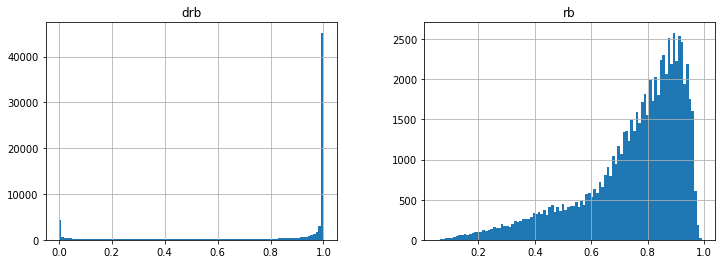

In [20]:
dfc.hist(['drb', 'rb'], bins=100, grid={'lw': 0.1}, figsize=(12, 4))

#### BTS Filter

Let us construct and apply an alert filter similar to that used for the ZTF Bright Transient Survey (BTS; [ATEL #11688](http://www.astronomerstelegram.org/?read=11688)).

We will filter out possible candidates at low Galactic latitudes. For that we will need a fast function to convert $R.A.$ and $Decl.$ into Galactic coordinates $l$ and $b$. [astropy SkyCoord-based solution would be notoriously slow]

In [21]:
# Rotation matrix for the conversion : x_galactic = R * x_equatorial (J2000)
# http://adsabs.harvard.edu/abs/1989A&A...218..325M
RGE = np.array([[-0.054875539, -0.873437105, -0.483834992],
                [+0.494109454, -0.444829594, +0.746982249],
                [-0.867666136, -0.198076390, +0.455983795]])

def radec2lb(ra, dec):
    """
        ra [deg]
        dec [deg]
        
        return l [deg], b [deg]
    """
    ra_rad, dec_rad = np.deg2rad(ra), np.deg2rad(dec)
    u = np.array([np.cos(ra_rad)*np.cos(dec_rad), 
                  np.sin(ra_rad)*np.cos(dec_rad), 
                  np.sin(dec_rad)])

    ug = np.dot(RGE, u)

    x, y, z = ug
    l = np.arctan2(y, x)
    b = np.arctan2(z, (x * x + y * y) ** .5)
    return np.rad2deg(l), np.rad2deg(b)

Set magnitude limit:

In [25]:
magnitude_limit = 20.5

Stripped-down version of the RCF filter:

In [22]:
def alert_filter__BTS(alert):
    filteron = False
    annotations = {}
    calccount = 10000
    bright = False
    nopointunderneath = True
    mover = True
    real = False
    slope = 0.0
    t_slope = 0.0
    drb = 0.0
    positivesubtraction = False
    brightstar = False
    scorr = 0.0
    latitude = True
    rock = False
    prevcandidates = alert['prv_candidates'] if alert['prv_candidates'] is not None else []
    m_now = alert['candidate']['magpsf']
    m_app = alert['candidate']['magap']
    t_now = alert['candidate']['jd']
    fid_now = alert['candidate']['fid']
    sgscore = alert['candidate']['sgscore1']
    sgscore2 = alert['candidate']['sgscore2']
    sgscore3 = alert['candidate']['sgscore3']
    srmag = alert['candidate']['srmag1']
    srmag2 = alert['candidate']['srmag2']
    srmag3 = alert['candidate']['srmag3']
    sgmag = alert['candidate']['sgmag1']
    simag = alert['candidate']['simag1']
    drbscore = alert['candidate']['drb']
    magnr = alert['candidate']['magnr']
    distnr = alert['candidate']['distnr']
    distpsnr1 = alert['candidate']['distpsnr1']
    distpsnr2 = alert['candidate']['distpsnr2']
    distpsnr3 = alert['candidate']['distpsnr3']
    scorr = alert['candidate']['scorr']
    fwhm = alert['candidate']['fwhm']
    elong = alert['candidate']['elong']
    nbad = alert['candidate']['nbad']
    chipsf = alert['candidate']['chipsf']
    l, b = radec2lb(alert['candidate']['ra'], alert['candidate']['dec'])
    gal_lat = b
    ssdistnr = alert['candidate']['ssdistnr']
    ssnamenr = alert['candidate']['ssnamenr']
    t_start = alert['candidate']['jdstarthist']
    age = t_now - t_start
    bright = m_now < magnitude_limit
    if (gal_lat and gal_lat < 7 and gal_lat > (-7)):
        latitude = False
        calccount -= 2
    if (alert['candidate']['isdiffpos'] and (alert['candidate']['isdiffpos'] == 't' or alert['candidate']['isdiffpos'] == '1')):
        positivesubtraction = True
        calccount -= 2
    if (drbscore and drbscore > 0.5):
        real = True
        calccount -= 2
    if (sgscore and distpsnr1 and sgscore > 0.76 and distpsnr1 < 2):
        nopointunderneath = False
        calccount -= 2
    if ((distpsnr1 and srmag and distpsnr1 < 20 and srmag < 15.0 and srmag > 0 and sgscore > 0.49) or (distpsnr2 and srmag2 and distpsnr2 < 20 and srmag2 < 15.0 and srmag2 > 0 and sgscore2 > 0.49) or (distpsnr3 and srmag3 and distpsnr3 < 20 and srmag3 < 15.0 and srmag3 > 0 and sgscore3 > 0.49) or (sgscore == 0.5 and distpsnr1 < 0.5 and (sgmag < 17 or srmag < 17 or simag < 17))):
        brightstar = True
        calccount -= 2
    for candidate in prevcandidates:
        calccount -= 2
        if (candidate['jd'] and candidate['magpsf'] and candidate['fid'] and candidate['isdiffpos'] and (candidate['isdiffpos'] == 't' or candidate['isdiffpos'] == '1')):
            dt = t_now - candidate['jd']
            if (dt > 0.02 and candidate['magpsf'] < 99):
                mover = False
                calccount -= 2
            if (dt != 0.0 and candidate['magpsf'] < 99):
                if (candidate['jd'] > t_slope and candidate['fid'] == fid_now):
                    t_slope = candidate['jd']
                    slope = (m_now - candidate['magpsf']) / dt
                    calccount -= 3
                calccount -= 2
            calccount -= 4
        if calccount < 0:
            break
    variablesource = False
    if (distnr < 0.4 and magnr < 19 and age > 90):
        variablesource = True
        calccount -= 2
    if (distnr < 0.8 and magnr < 17 and age > 90):
        variablesource = True
        calccount -= 2
    if (distnr < 1.2 and magnr < 15 and age > 90):
        variablesource = True
        calccount -= 2
    annotations['magnitude'] = m_now
    annotations['sgscore'] = sgscore
    annotations['slope'] = slope
    annotations['drbscore'] = drbscore
    annotations['magnr'] = magnr
    annotations['distnr'] = distnr
    annotations['scorr'] = scorr
    annotations['gal_lat'] = gal_lat
    annotations['ssdistnr'] = ssdistnr
    annotations['ssnamenr'] = ssnamenr
    annotations['variableSource'] = variablesource
    annotations['age'] = age
    filteron = latitude and bright and nopointunderneath and ((not mover)) and real and positivesubtraction and ((not brightstar))
    
    return filteron, annotations

Full RCF filter:

In [26]:
def alert_filter__RCF(alert):
    filteron = False
    annotations={}
    calccount=10000
    prevcandidates = alert['prv_candidates'] if alert['prv_candidates'] is not None else []
    cand = alert['candidate']
    m_now = cand['magpsf']
    m_app = cand['magap']
    t_now = cand['jd']
    fid_now = cand['fid']
    sgscore1 = cand['sgscore1']
    sgscore2 = cand['sgscore2']
    sgscore3 = cand['sgscore3']
    srmag1 = cand['srmag1']
    srmag2 = cand['srmag2']
    srmag3 = cand['srmag3']
    sgmag1 = cand['sgmag1']
    simag1 = cand['simag1']
    szmag1 = cand['szmag1']
    rbscore = cand['rb']
    magnr = cand['magnr']
    distnr = cand['distnr']
    distpsnr1 = cand['distpsnr1']
    distpsnr2 = cand['distpsnr2']
    distpsnr3 = cand['distpsnr3']
    scorr = cand['scorr']
    fwhm = cand['fwhm']
    elong = cand['elong']
    nbad = cand['nbad']
    chipsf = cand['chipsf']
    l, b = radec2lb(alert['candidate']['ra'], alert['candidate']['dec'])
    gal_lat = b
    ssdistnr = cand['ssdistnr']
    ssnamenr = cand['ssnamenr']
    t_start = cand['jdstarthist']
    neargaia = cand['neargaia']
    maggaia = cand['maggaia']
    neargaiabright = cand['neargaiabright']
    maggaiabright = cand['maggaiabright']
    isdiffpos = cand['isdiffpos']
    drb = cand['drb']
    age = t_now - t_start
    if (distpsnr1 < 0):
        distpsnr1 = 99
        calccount -= 2
    if (distpsnr2 < 0):
        distpsnr2 = 99
        calccount -= 2
    if (distpsnr3 < 0):
        distpsnr3 = 99
        calccount -= 2
    if (distnr < 0):
        distnr = 99
        calccount -= 2
    bright = m_now < magnitude_limit
    latitude = True
    if (gal_lat < 7 and gal_lat > (-7)):
        latitude = False
        calccount -= 2
    positivesubtraction = False
    if (isdiffpos == 't' or isdiffpos == '1'):
        positivesubtraction = True
        calccount -= 2
    pointunderneath = False
    if (sgscore1 > 0.76 and distpsnr1 > 0 and distpsnr1 < 2):
        pointunderneath = True
        calccount -= 2
    if (sgscore1 == 0.5 and distpsnr1 > 0 and distpsnr1 < 0.5):
        if ((sgmag1 < 17 and sgmag1 > 0) or (srmag1 < 17 and srmag1 > 0) or (simag1 < 17 and simag1 > 0) or (szmag1 < 17 and szmag1 > 0)):
            pointunderneath = True
            calccount -= 2
        calccount -= 2
    if (sgscore1 > 0.2):
        if ((distpsnr1 < 3) and (age > 90)):
            if ((sgmag1 < 16 and sgmag1 > 0) or (srmag1 < 16 and srmag1 > 0) or (simag1 < 16 and simag1 > 0) or (szmag1 < 16 and szmag1 > 0)):
                pointunderneath = True
                calccount -= 2
            calccount -= 2
        if (distpsnr1 < 1):
            if (srmag1 > 0 and szmag1 > 0 and srmag1 - szmag1 > 3.0):
                pointunderneath = True
                calccount -= 2
            if (srmag1 > 0 and simag1 > 0 and srmag1 - simag1 > 3.0):
                pointunderneath = True
                calccount -= 2
            calccount -= 3
        calccount -= 3
    real = False
    if (rbscore > 0.2):
        real = True
        calccount -= 2
    if (rbscore < 0.35):
        if (neargaia < 1.0 and neargaia > 0.0 and maggaia < 17.0 and maggaia > 0.0):
            real = False
            calccount -= 2
        if (distpsnr1 < 1.0 and (srmag1 > 0 and srmag1 < 17.0 or simag1 > 0 and simag1 < 17.0 or szmag1 > 0 and szmag1 < 16.5) and sgscore1 > 0.49):
            real = False
            calccount -= 2
        calccount -= 3
    if (rbscore < 0.45):
        if (neargaia < 1.5 and neargaia > 0.0 and maggaia < 15.5 and maggaia > 0.0):
            real = False
            calccount -= 2
        if (distpsnr1 < 1.5 and (srmag1 > 0 and srmag1 < 15.5 or simag1 > 0 and simag1 < 15.5 or szmag1 > 0 and szmag1 < 15.0) and sgscore1 > 0.49):
            real = False
            calccount -= 2
        calccount -= 3
    if (drb < 0.1):
        real = False
        calccount -= 2
    brightstar = False
    if (neargaiabright > 0 and maggaiabright > 0):
        if (neargaiabright < 20 and maggaiabright < 12):
            brightstar = True
            calccount -= 2
        calccount -= 2
    if (neargaia > 0 and maggaia > 0):
        if ((neargaia < 1.5) and (maggaia < 15.0) and (age > 15)):
            brightstar = True
            calccount -= 2
        if ((neargaia < 1.0) and (maggaia < 16.5) and (age > 30)):
            brightstar = True
            calccount -= 2
        calccount -= 3
    if (srmag1 > 0):
        if (distpsnr1 < 20 and srmag1 < 12.0 and sgscore1 > 0.49):
            brightstar = True
            calccount -= 2
        if (distpsnr1 < 20 and srmag1 < 15.0 and sgscore1 > 0.8):
            brightstar = True
            calccount -= 2
        if (distpsnr1 < 5 and srmag1 < 15.0 and sgscore1 > 0.49):
            brightstar = True
            calccount -= 2
        if (distpsnr1 < 1.1 and srmag1 < 16.5 and sgscore1 > 0.49):
            brightstar = True
            calccount -= 2
        calccount -= 5
    if (srmag2 > 0):
        if (distpsnr2 < 20 and srmag2 < 12.0 and sgscore2 > 0.49):
            brightstar = True
            calccount -= 2
        if (distpsnr2 < 20 and srmag2 < 15.0 and sgscore2 > 0.8):
            brightstar = True
            calccount -= 2
        if (distpsnr2 < 5 and srmag2 < 15.0 and sgscore2 > 0.49):
            brightstar = True
            calccount -= 2
        if (distpsnr2 < 1.1 and srmag2 < 16.5 and sgscore2 > 0.49):
            brightstar = True
            calccount -= 2
        calccount -= 5
    if (srmag3 > 0):
        if (distpsnr3 < 20 and srmag3 < 12.0 and sgscore3 > 0.49):
            brightstar = True
            calccount -= 2
        if (distpsnr3 < 20 and srmag3 < 15.0 and sgscore3 > 0.8):
            brightstar = True
            calccount -= 2
        if (distpsnr3 < 5 and srmag3 < 15.0 and sgscore3 > 0.49):
            brightstar = True
            calccount -= 2
        if (distpsnr3 < 1.1 and srmag3 < 16.5 and sgscore3 > 0.49):
            brightstar = True
            calccount -= 2
        calccount -= 5
    if (simag1 > 0):
        if (distpsnr1 < 20 and simag1 < 11.5 and sgscore1 > 0.49):
            brightstar = True
            calccount -= 2
        if (distpsnr1 < 20 and simag1 < 14.5 and sgscore1 > 0.8):
            brightstar = True
            calccount -= 2
        if (distpsnr1 < 5 and simag1 < 14.5 and sgscore1 > 0.49):
            brightstar = True
            calccount -= 2
        if (distpsnr1 < 1.1 and simag1 < 16.0 and sgscore1 > 0.49):
            brightstar = True
            calccount -= 2
        calccount -= 5
    if (szmag1 > 0):
        if (distpsnr1 < 10 and szmag1 < 11.5 and sgscore1 > 0.49):
            brightstar = True
            calccount -= 2
        if (distpsnr1 < 10 and szmag1 < 14.0 and sgscore1 > 0.8):
            brightstar = True
            calccount -= 2
        if (distpsnr1 < 2.5 and szmag1 < 14.0 and sgscore1 > 0.49):
            brightstar = True
            calccount -= 2
        if (distpsnr1 < 0.9 and szmag1 < 15.5 and sgscore1 > 0.49):
            brightstar = True
            calccount -= 2
        calccount -= 5
    mover = True
    for prevcandidate in prevcandidates:
        calccount -= 2
        if prevcandidate['isdiffpos'] == 't' or prevcandidate['isdiffpos'] == '1':
            dt = t_now - prevcandidate['jd']
            if (dt > 0.02 and prevcandidate['magpsf'] < 99):
                mover = False
                calccount -= 2
            calccount -= 3
        if calccount < 0:
            break
    prevpasscount = 0
    peakmag = 99
    for prevcandidate in prevcandidates:
        calccount -= 2
        if prevcandidate['isdiffpos'] == 't' or prevcandidate['isdiffpos'] == '1':
            dt = t_now - prevcandidate['jd']
            if (dt != 0.0 and prevcandidate['magpsf'] < 99):
                if (prevcandidate['fid'] == fid_now):
                    prevbright = prevcandidate['magpsf'] < 19.0
                    if (prevbright):
                        prevpasscount = prevpasscount + 1
                        calccount -= 2
                    if (prevcandidate['magpsf'] < peakmag):
                        peakmag = prevcandidate['magpsf']
                        calccount -= 2
                    calccount -= 4
                calccount -= 2
            calccount -= 3
        if calccount < 0:
            break
    variablesource = False
    atmax = (m_now <= peakmag)
    if ((age > 90) and (prevpasscount >= 3 - 1 * (age > 90) - 1 * (age > 360)) and ((not (atmax and m_now < 18.5))) and (magnr > 0)):
        if (distnr < 0.4 and magnr < 19.5):
            variablesource = True
            calccount -= 2
        if (distnr < 0.8 and magnr < 17.5):
            variablesource = True
            calccount -= 2
        if (distnr < 1.2 and magnr < 15.5):
            variablesource = True
            calccount -= 2
        calccount -= 4
    if (maggaia > 0 and neargaia > 0):
        if ((neargaia < 0.35) and (maggaia < 17.0) and (age > 30)):
            variablesource = True
            calccount -= 2
        if ((neargaia < 0.35) and (maggaia < 19.0) and (age > 300) and (m_now > 18.5)):
            variablesource = True
            calccount -= 2
        if ((neargaia < 0.2) and (maggaia < 18.0) and (age > 90)):
            variablesource = True
            calccount -= 2
        calccount -= 4
    if (magnr > 0 and magnr < m_now - 1):
        if ((age > 90) and (distnr < 0.5) and ((not atmax))):
            variablesource = True
            calccount -= 2
        calccount -= 2
    rock = False
    rock = (ssdistnr >= 0 and ssdistnr < 15)
    annotations['jd'] = t_now
    annotations['magnitude'] = m_now
    annotations['age'] = age
    annotations['dt'] = age
    annotations['peakmag'] = peakmag
    annotations['prevpasscount'] = prevpasscount
    annotations['atmax'] = atmax
    annotations['rbscore'] = rbscore
    annotations['magnr'] = magnr
    annotations['distnr'] = distnr
    annotations['srmag1'] = srmag1
    annotations['distpsnr1'] = distpsnr1
    annotations['sgscore1'] = sgscore1
    annotations['maggaia'] = maggaia
    annotations['neargaia'] = neargaia
    annotations['gal_lat'] = gal_lat
    annotations['drb'] = drb
    filteron = latitude and bright and ((not pointunderneath)) and ((not mover)) and real and positivesubtraction and ((not brightstar)) and ((not rock)) and ((not variablesource))
    return filteron, annotations

In [28]:
def apply_filter(p):
    with open(p, 'r') as f:
        alert = json.load(f)
        # stripped-down version of the RCF filter:
#         fon, anno = alert_filter__BTS(alert)
        # full version of the RCF filter:
        fon, anno = alert_filter__RCF(alert)
        if fon:
            return alert
        else:
            return None

with mp.Pool(processes=np.min((10, n_cpu))) as p:
    alerts_BTS = [x for x in tqdm(p.imap(apply_filter, path.glob('*.json')), total=n_alerts) if x is not None]
    
print(f'Number of alerts that passed the BTS filter: {len(alerts_BTS)}')

100%|██████████| 75194/75194 [00:10<00:00, 7095.45it/s]


Number of alerts that passed the BTS filter: 180


Bucketize alerts from the same objects:

In [29]:
objectIds = set([a['objectId'] for a in alerts_BTS])
objects = {o: [] for o in objectIds}
for a in alerts_BTS:
    objects[a['objectId']].append(a)
    
print(f'Number of objects that passed the RCF filter: {len(objects)}')

Number of objects that passed the RCF filter: 140


Submit a candidate to the GROWTH marshal.

GROWTH marshal credentials:

In [43]:
username = 'USERNAME'
password = 'PASSWORD'

Get your `programidx` for the `TESS` program on the marshal:

In [51]:
r = requests.post('http://skipper.caltech.edu:8080/cgi-bin/growth/list_programs.cgi', 
                  auth=(username, password))
programs = json.loads(r.text)

for index, program in enumerate(programs):
    if program['name'] == "TESS":
        programidx = program['programidx']
        programidx = program['programidx']
        break
else:
    raise Exception('You have not been added to the TESS program on marshal, contact Lin.')

print('programidx: ', programidx)

programidx:  4


In [52]:
url1 = 'http://skipper.caltech.edu:8080/cgi-bin/growth/ingest_avro_id.cgi'
url2 = 'http://skipper.caltech.edu:8080/cgi-bin/growth/save_cand_growth.cgi'

def on_button_clicked(b):
    oid = b.description

    payload = {'programidx': str(programidx), 'name': oid, 'submit': True}
    r = requests.post(url1, auth=(username, password), params=payload)
#     print(r.text)
#     print('------------------------')

    payload = {'program': '78', 'candname': oid, 'submit': 'SAVE'}
    r = requests.post(url2, auth=(username, password), params=payload)
    
    resp = r.text
#     print(resp)
    
    if 'Candidate already in sources table for this program' in resp:
        print(f'{oid}: candidate already in sources table for the TESS program')
    elif 'has already been saved for program' in resp:
        print(f'{oid}: candidate has already been saved for the TESS program')
    elif 'does not belong to program':
        # print(f'{oid}: candidate does not belong to program, whatever this might mean, I have no clue')
        print(f'{oid}: candidate saved to the TESS program')
    elif 'does not exist':
        print(f'{oid}: candidate does not exist? Likely a marshal problem')
    else:
        print(f'{oid}: candidate _probably_ saved?')

Display:

Button(button_style='info', description='ZTF18aawhlgv', style=ButtonStyle(), tooltip='Save to GROWTH marshal')

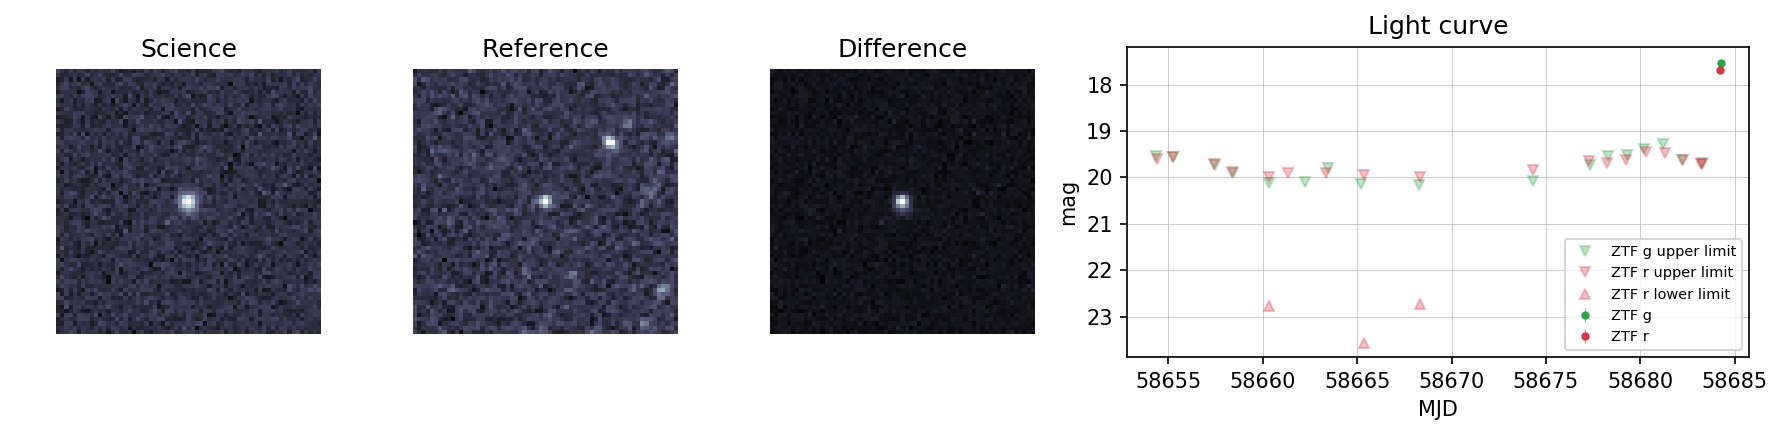

Button(button_style='info', description='ZTF18abmpvpg', style=ButtonStyle(), tooltip='Save to GROWTH marshal')

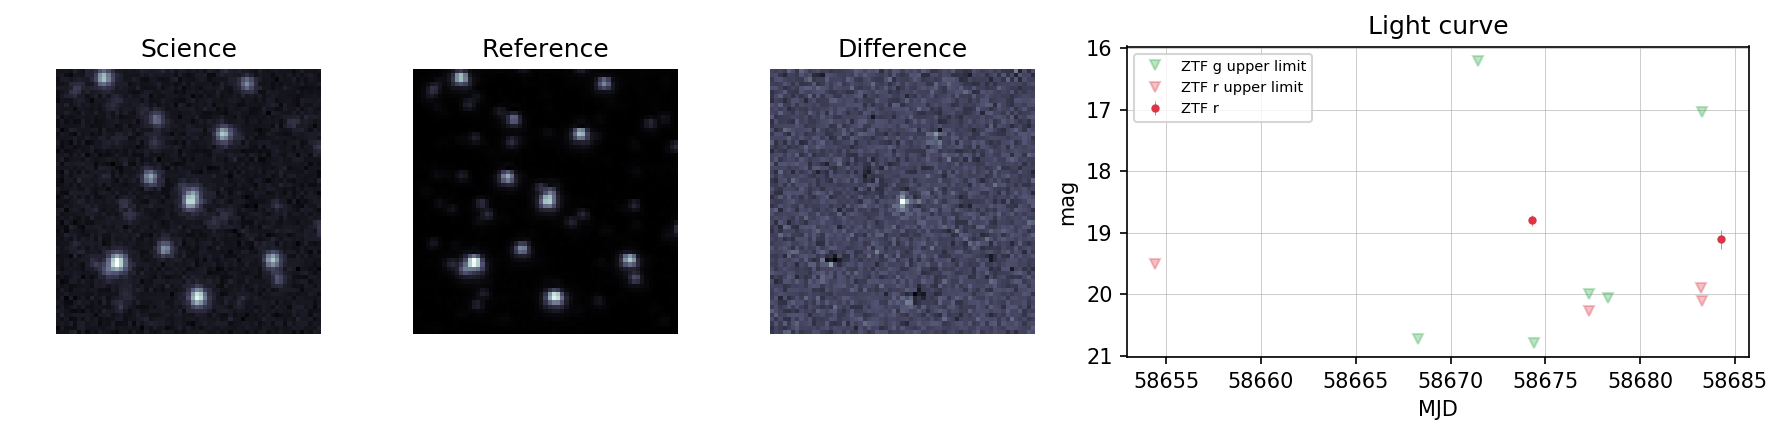

Button(button_style='info', description='ZTF19abbwrdf', style=ButtonStyle(), tooltip='Save to GROWTH marshal')

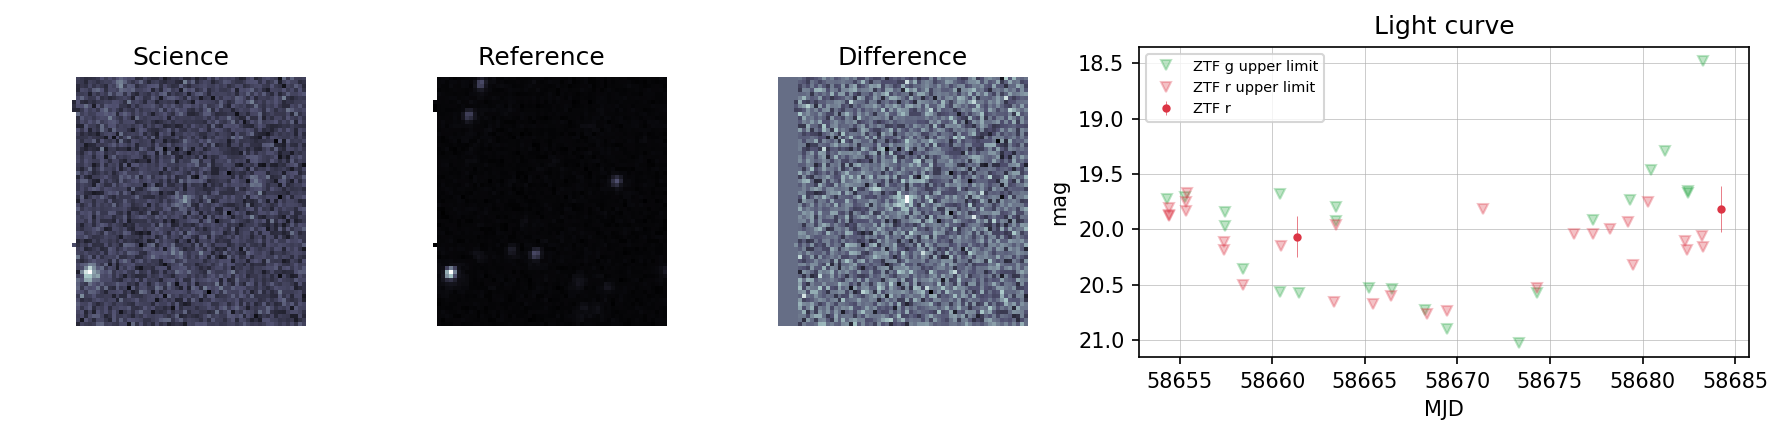

Button(button_style='info', description='ZTF18aarwxum', style=ButtonStyle(), tooltip='Save to GROWTH marshal')

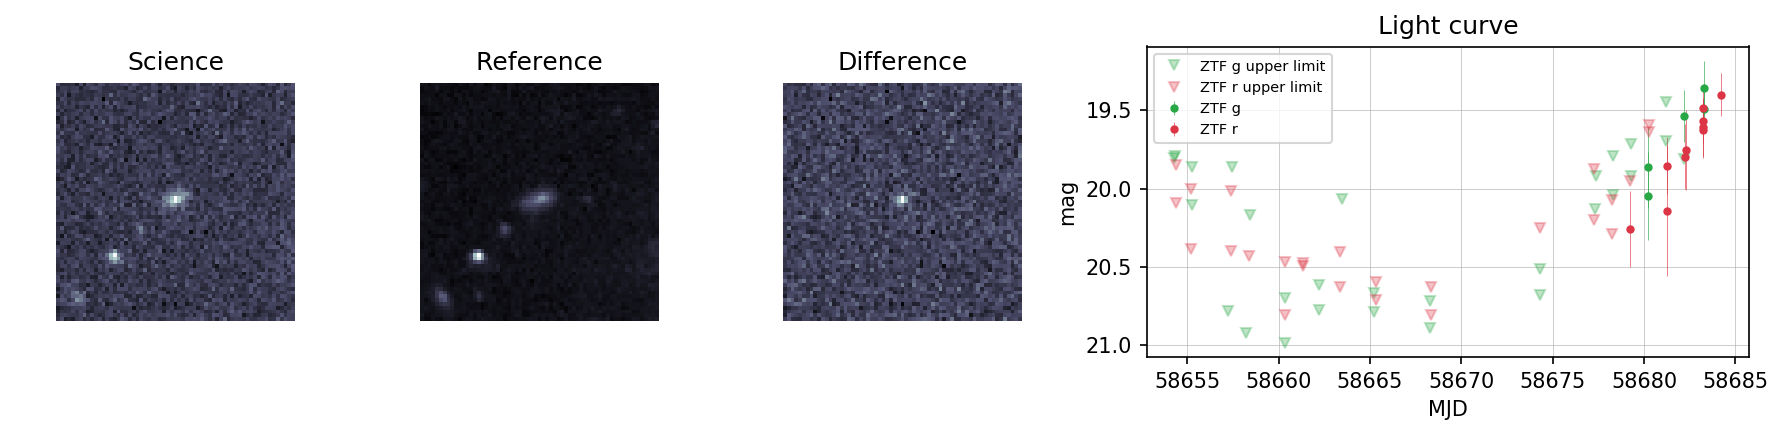

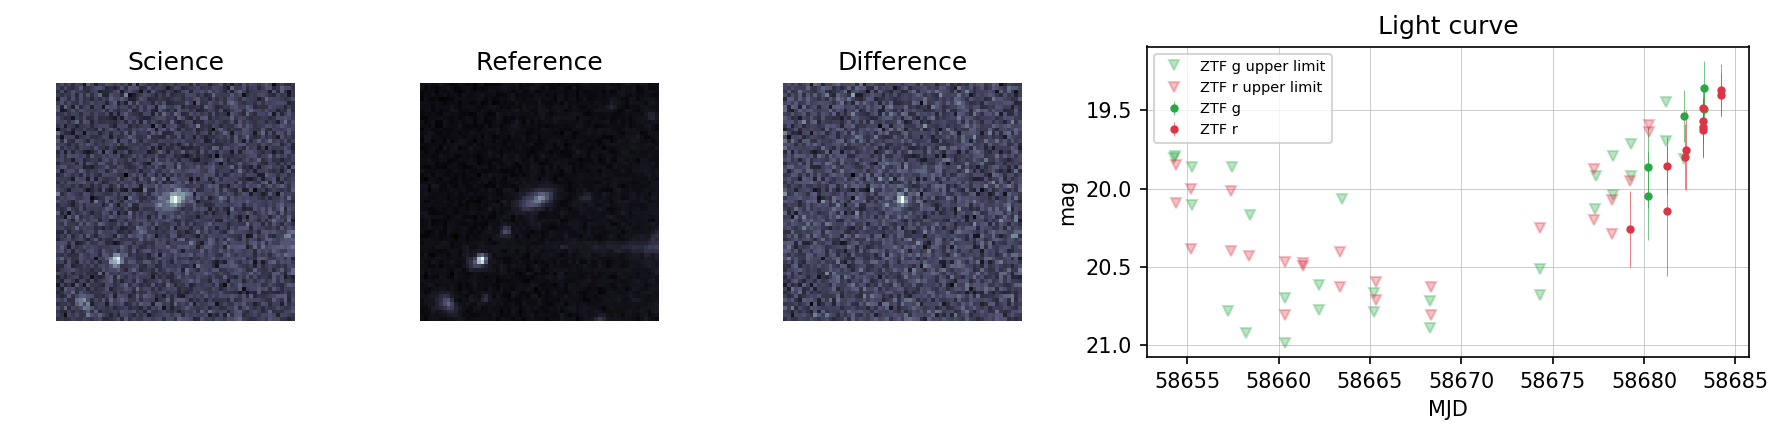

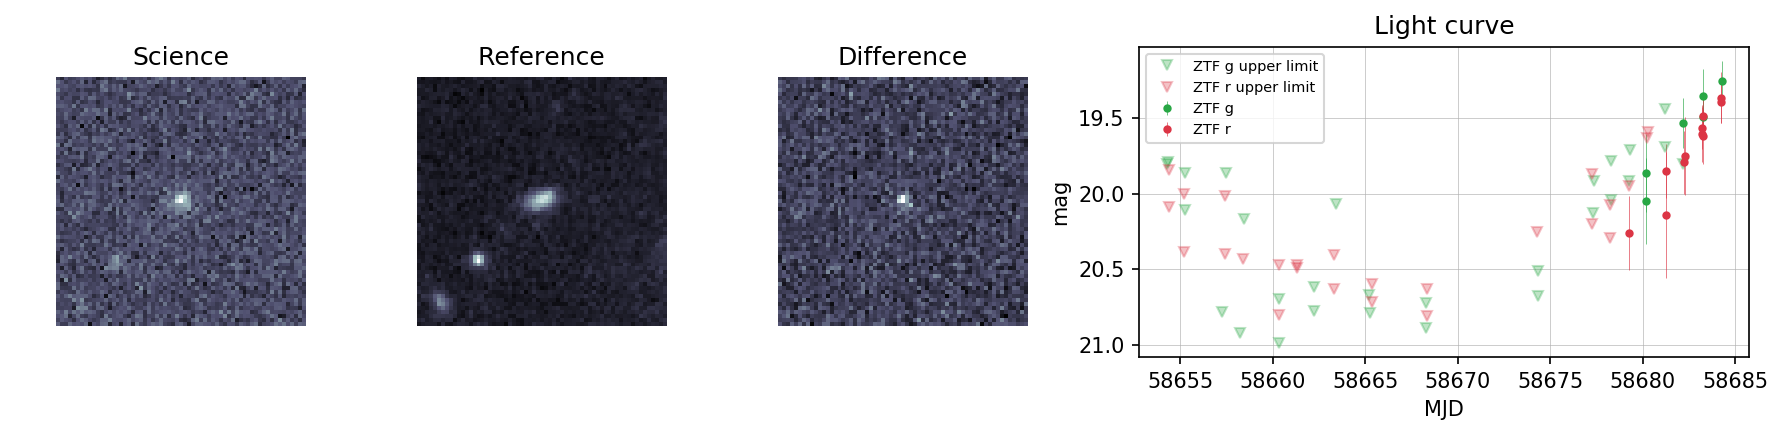

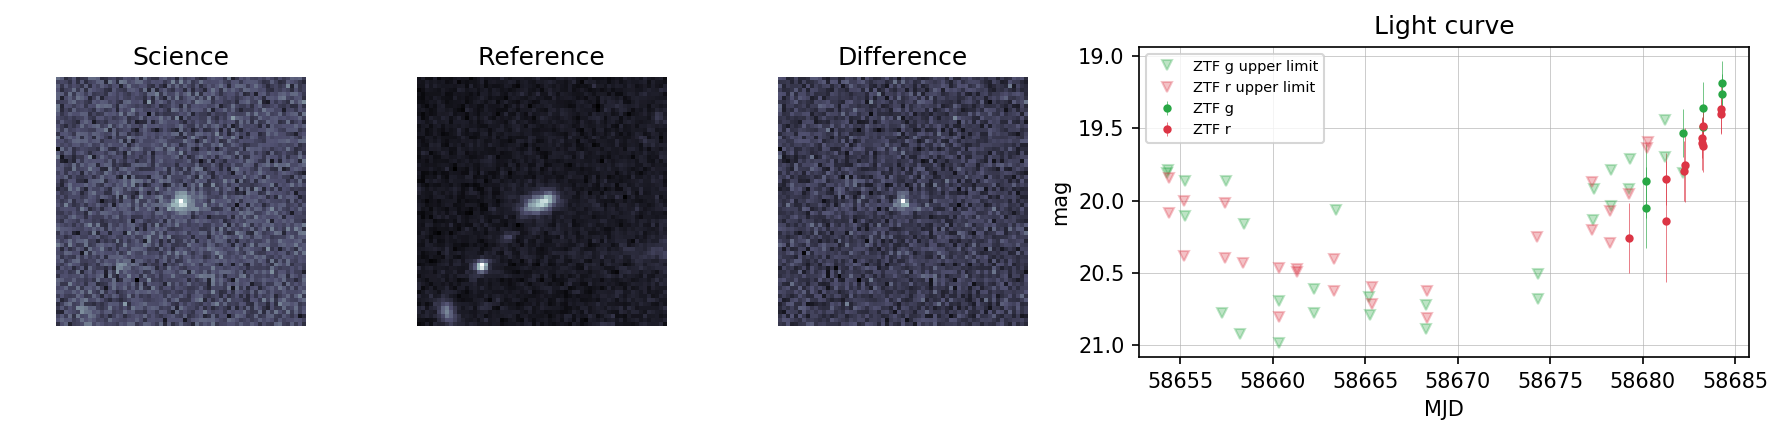

Button(button_style='info', description='ZTF19abgbtla', style=ButtonStyle(), tooltip='Save to GROWTH marshal')

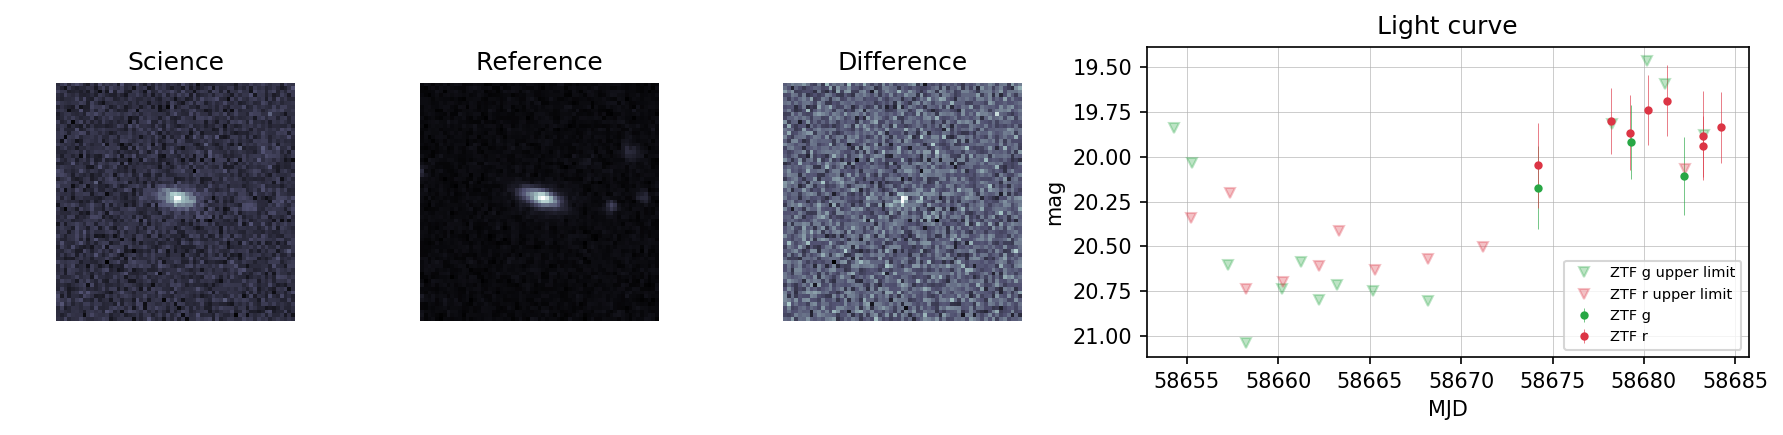

In [54]:
match_radius_arcsec = 1.5
star_galaxy_threshold = 0.3

for o, alerts in objects.items():
#     if o == 'ZTF18aawhlgv':
    display(HTML(f'<b>{o}</b>'))
    button = widgets.Button(description=o,
                            button_style='info',
                            tooltip='Save to GROWTH marshal')
    button.on_click(on_button_clicked)
    display(button)
    for alert in alerts:
        display(HTML(f"candid: {alert['candid']}. <a target='_blank' href='https://kowalski.caltech.edu/lab/ztf-alerts/{alert['candid']}'>See in ZTF Alert Lab</a"))
        tr = make_triplet(alert)
        df = make_dataframe(alert)
        _, lc_candid = assemble_lc(df, objectId=alert['objectId'], composite=False,
                                   match_radius_arcsec=match_radius_arcsec,
                                   star_galaxy_threshold=star_galaxy_threshold)
        plot_triplet_lc(tr, lc_candid)

    display(HTML('<hr>'))
    
#     if o == 'ZTF19abgbtla':
#         break

display(HTML("<br>"))